# Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn
from pathlib import Path

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
dataset_path = Path(r"C:\Users\197as\OneDrive\Documents\PBL\Indian")

# Data preperation

In [4]:
train_dir = dataset_path / "train"
test_dir = dataset_path / "test"

train_dir, test_dir

(WindowsPath('C:/Users/197as/OneDrive/Documents/PBL/Indian/train'),
 WindowsPath('C:/Users/197as/OneDrive/Documents/PBL/Indian/test'))

# Transforming data with `torchvision.transforms`(with data augmentation)

In [5]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
])

# Loading image data using `ImageFolder`

In [6]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transforms)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transforms)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 29923
     Root location: C:\Users\197as\OneDrive\Documents\PBL\Indian\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 12822
     Root location: C:\Users\197as\OneDrive\Documents\PBL\Indian\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

# Dataloader

In [7]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

# `train_step()`, `test_step()` and `train()`

In [8]:
from tqdm.auto import tqdm
import torch.utils.data

def train_step(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        device=device,
        ):
    model.train()

    train_loss = 0

    for batch, (X,Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, Y)

        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss = train_loss / len(dataloader)

    return train_loss

#========================================================================================

def test_step(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        device=device,
        ):
    model.eval()

    test_loss = 0

    with torch.inference_mode():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
          
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, Y)
            test_loss += loss.item()

    test_loss = test_loss / len(dataloader)
    return test_loss

#========================================================================================

def train(
        model: torch.nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
        epochs: int = 5
        ):
    results = {
        "train_loss": [],
        "test_loss": [],
    }
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)
        
        test_loss = test_step(model=model,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn,
                              device=device)
        
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}")
        
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    return results

c:\Users\197as\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model

In [9]:
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=3,
                stride=2,
            ),
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=3,
                stride=2,
            ),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*15*15,
                      out_features=output_shape)
        )

    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [ ]:
from timeit import default_timer as timer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model_1 = TinyVGG(
    input_shape=3, # Number of color channels in out image data
    hidden_units=260,
    output_shape=len(train_data.classes),
    ).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

start_time = timer()

model_0_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


 20%|██        | 1/5 [10:02<40:11, 602.85s/it]

Epoch: 0 | Train loss: 0.7592 | Test loss: 0.0070


In [18]:
import matplotlib.pyplot as plt

def plot_train_curves(results: dict[str, list[float]]):
    """Plots training curve of a results dictionary."""
    # Get the loss values of the results dictionary(training and test)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # Setup a plot
    plt.figure(figsize=(15,7))

    # Plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

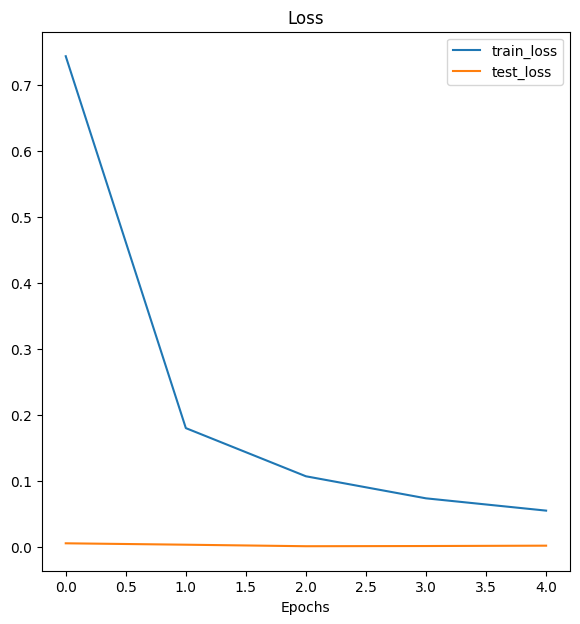

In [12]:
plot_train_curves(model_0_results)

# Prediction on custom image

In [19]:
import torchvision

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: list[str] = None,
                        device=device):
    """Make a prediction on a target image and plot the image and prediction."""
    custom_image_uint8 = torchvision.io.read_image(image_path)
    custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))])
    custom_image_transformed = custom_image_transform(custom_image_uint8)
    custom_image = custom_image_transformed.type(torch.float32) / 255
    custom_image = custom_image.unsqueeze(0)

    model.eval()
    with torch.inference_mode():
        custom_image_pred = model(custom_image.to(device))
    
    custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
    custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
    return class_names[custom_image_pred_label]

In [24]:
pred_and_plot_image(
    model=model_1,
    image_path=Path(r"C:\Users\197as\OneDrive\Documents\PBL\Indian\70.jpeg"),
    class_names=test_data.classes,
    device=device
)

'R'

# Save and Load

In [15]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create a model save
MODEL_NAME = "cnn_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(model_1.state_dict(),
           MODEL_SAVE_PATH)



Saving model to: models\cnn_model.pth


In [16]:
import torch

torch.manual_seed(42)

loaded_model_1 = TinyVGG(
    input_shape=3, # Number of color channels in out image data
    hidden_units=260,
    output_shape=len(train_data.classes),
    ).to(device)

# Load in the save state_dict()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Send the model to target device
print(loaded_model_1.state_dict())


C:\Users\197as\AppData\Local\Temp\ipykernel_644\1607096181.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


OrderedDict({'conv_block_1.0.weight': tensor([[[[ 0.1161,  0.1419, -0.0713],
          [ 0.1581, -0.0483,  0.0297],
          [-0.1254,  0.0945,  0.1428]],

         [[-0.1562,  0.1684,  0.0264],
          [ 0.1276,  0.0333,  0.0967],
          [-0.0493,  0.1452,  0.0158]],

         [[-0.1492,  0.0113, -0.1310],
          [-0.0866, -0.1170,  0.0937],
          [-0.2366, -0.1526, -0.1152]]],


        [[[-0.1506, -0.0073, -0.2421],
          [ 0.1550, -0.1647,  0.1125],
          [-0.0150, -0.0858,  0.0654]],

         [[ 0.0219,  0.1593,  0.0024],
          [-0.0596,  0.0717, -0.0659],
          [ 0.0532,  0.1664,  0.0764]],

         [[-0.1619,  0.0447, -0.0452],
          [ 0.0366, -0.1615, -0.2536],
          [-0.1626, -0.2162,  0.0754]]],


        [[[ 0.0955,  0.1210,  0.0833],
          [ 0.0387,  0.1888, -0.1196],
          [ 0.0507, -0.0939,  0.0839]],

         [[-0.0418,  0.0623, -0.0625],
          [ 0.1907, -0.1156, -0.1477],
          [-0.0805,  0.1811,  0.0443]],

      

In [17]:
pred_and_plot_image(
    model=loaded_model_1,
    image_path=Path(r"C:\Users\197as\OneDrive\Documents\PBL\Indian\k.jpeg"),
    class_names=test_data.classes,
    device=device
)

'K'